In [1]:
#@title Libraries

#Mount google drive and import personal modules
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/speeches/')

import datetime
import numpy as np
import pandas as pd
import pandas_datareader as web
from progressbar import progressbar
from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

Mounted at /content/drive/


In [24]:
#@title Functions

def quote(stock, d, flag = 1):
  try:
    q = web.DataReader(stock, data_source='yahoo', 
                        start= d - datetime.timedelta(days = 20), 
                        end=d + datetime.timedelta(days = 20))
    a = q.loc[q.index >= d]['Close']
    b = q.loc[q.index < d]['Close']
    if flag==1: #2-wk price after
      return (a[:10][9]-a[:10][0])/a[:10][0]
    else: #2-wk price before
      return (b[-10:][9]-b[-10:][0])/b[-10:][0]
  except:
    return 0

def market(d, flag = 1):
    try:
      q = web.DataReader('^GSPC', data_source='yahoo', 
                        start= d - datetime.timedelta(days = 20), 
                        end=d + datetime.timedelta(days = 20))
      a = q.loc[q.index >= d]['Close']
      b = q.loc[q.index < d]['Close']
      if flag==1: #2-wk price after
        return (a[:10][9]-a[:10][0])/a[:10][0]
      else: #2-wk price before
        return (b[-10:][9]-b[-10:][0])/b[-10:][0]
    except:
      return 0

def daily_quote(stock, d, i):
  try:
    q = web.DataReader(stock, data_source='yahoo', 
                        start= d - datetime.timedelta(days = 20), 
                        end=d + datetime.timedelta(days = 20))
    t = pd.concat([q.loc[q.index < d]['Close'][-10:], 
                   q.loc[q.index >= d]['Close'][:10]])
    if i<0:
      return (t[i+10]-t[0])/t[0]
    else:
      return (t[i+10]-t[9])/t[9]
  except:
    return 0

def daily_market(d, i):
  try:
    q = web.DataReader('^GSPC', data_source='yahoo', 
                        start= d - datetime.timedelta(days = 20), 
                        end=d + datetime.timedelta(days = 20))
    t = pd.concat([q.loc[q.index < d]['Close'][-10:], 
                   q.loc[q.index >= d]['Close'][:10]])
    if i<0:
      return (t[i+10]-t[0])/t[0]
    else:
      return (t[i+10]-t[9])/t[9]
  except:
    return 0

def daily_quote1(stock, d, i):
  try:
    q = web.DataReader(stock, data_source='yahoo', 
                        start= d - datetime.timedelta(days = 20), 
                        end=d + datetime.timedelta(days = 20))
    t = pd.concat([q.loc[q.index < d]['Close'][-10:], 
                   q.loc[q.index >= d]['Close'][:10]])
    return (t[i+10]-t[0])/t[0]
  except:
    return 0

def daily_market1(d, i):
  try:
    q = web.DataReader('^GSPC', data_source='yahoo', 
                        start= d - datetime.timedelta(days = 20), 
                        end=d + datetime.timedelta(days = 20))
    t = pd.concat([q.loc[q.index < d]['Close'][-10:], 
                   q.loc[q.index >= d]['Close'][:10]])

    return (t[i+10]-t[0])/t[0]
  except:
    return 0

In [8]:
acq = pd.read_csv('/content/drive/MyDrive/speeches/15company.csv')
acq['Announce Date'] = pd.to_datetime(acq['Announce Date'])
acq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Deal Type                     1955 non-null   object        
 1   Announce Date                 1955 non-null   datetime64[ns]
 2   Target Name                   1955 non-null   object        
 3   Acquirer Name                 1955 non-null   object        
 4   Seller Name                   988 non-null    object        
 5   Announced Total Value (mil.)  606 non-null    float64       
 6   Payment Type                  1942 non-null   object        
 7   TV/EBITDA                     1955 non-null   object        
 8   Deal Status                   1955 non-null   object        
 9   Target Industry Sector        1955 non-null   object        
 10  Ticker                        1955 non-null   object        
dtypes: datetime64[ns](1), float64(

In [9]:
acq.head()

,Deal Type,Announce Date,Target Name,Acquirer Name,Seller Name,Announced Total Value (mil.),Payment Type,TV/EBITDA,Deal Status,Target Industry Sector,Ticker
0,M&A,2017-09-20,Kioxia Corp,"Apple Inc,Hoya Corp,SK Hynix Inc,Seagate Techn...",Toshiba Corp,17957.62,Cash,,Completed,Technology,APPL
1,M&A,2011-06-30,Nortel's Patent Portfolio,"EMC Corp,Sony Corp,Apple Inc,Microsoft Corp,Te...",Nortel Networks Corp,4500.00,Cash,,Completed,Communications,APPL
2,M&A,2014-05-28,"Beats Electronics LLC,Beats Music LLC",Apple Inc,"Vivendi SE,Private Investor,Carlyle Group Inc/...",3000.00,Cash,,Completed,"Consumer, Cyclical, Technology",APPL
3,M&A,2019-07-25,Smartphone modem business,Apple Inc,Intel Corp,1000.00,Cash,,Completed,Communications,APPL
4,M&A,1996-12-20,Next Computer Inc,Apple Inc,NaN,400.00,Undisclosed,,Completed,N.A.,APPL


In [10]:
acq.loc[acq.Ticker=='APPL', 'Ticker'] = 'AAPL'
acq.Ticker.unique()

array(['AAPL', 'MSFT', 'AMZN', 'ADBE', 'GOOGL', 'QCOM', 'ORCL', 'INTC',
       'IBM', 'CMCSA', 'T', 'FB', 'CRM', 'NVDA', 'TXN'], dtype=object)

In [16]:
df01 = acq.iloc[:,np.array([1,2,3,9,10])]
df02 = pd.concat([df01] * 18).reset_index() #duplicate rows for before/after M&A tracking
df02.columns = ['acqID', 'Announce Date', 'Target Name', 'Acquirer Name',
       'Target Industry Sector', 'Ticker']

In [18]:
df02['day'] = np.concatenate((np.array([-9]*1955), np.array([-8]*1955),
                              np.array([-7]*1955), np.array([-6]*1955),
                              np.array([-5]*1955), np.array([-4]*1955),
                              np.array([-3]*1955), np.array([-2]*1955),
                              np.array([-1]*1955),
                              np.zeros(1955),np.ones(1955),
                              np.array([2]*1955), np.array([3]*1955),
                              np.array([4]*1955), np.array([5]*1955),
                              np.array([6]*1955), np.array([7]*1955),
                              np.array([8]*1955)
                              )).astype('int64')

In [20]:
df02.iloc[1950:1960], df02.iloc[3905:3915], df02.iloc[5860:5870], df02.iloc[7815:7825] 

(      acqID Announce Date  ... Ticker day
 1950   1950    1998-01-22  ...    TXN  -9
 1951   1951    1997-11-19  ...    TXN  -9
 1952   1952    1997-03-03  ...    TXN  -9
 1953   1953    1996-05-06  ...    TXN  -9
 1954   1954    1996-06-05  ...    TXN  -9
 1955      0    2017-09-20  ...   AAPL  -8
 1956      1    2011-06-30  ...   AAPL  -8
 1957      2    2014-05-28  ...   AAPL  -8
 1958      3    2019-07-25  ...   AAPL  -8
 1959      4    1996-12-20  ...   AAPL  -8
 
 [10 rows x 7 columns],       acqID Announce Date  ... Ticker day
 3905   1950    1998-01-22  ...    TXN  -8
 3906   1951    1997-11-19  ...    TXN  -8
 3907   1952    1997-03-03  ...    TXN  -8
 3908   1953    1996-05-06  ...    TXN  -8
 3909   1954    1996-06-05  ...    TXN  -8
 3910      0    2017-09-20  ...   AAPL  -7
 3911      1    2011-06-30  ...   AAPL  -7
 3912      2    2014-05-28  ...   AAPL  -7
 3913      3    2019-07-25  ...   AAPL  -7
 3914      4    1996-12-20  ...   AAPL  -7
 
 [10 rows x 7 columns],    

In [11]:
df02.head()

,acqID,Announce Date,Target Name,Acquirer Name,Target Industry Sector,Ticker,day
0,0,2017-09-20,Kioxia Corp,"Apple Inc,Hoya Corp,SK Hynix Inc,Seagate Techn...",Technology,AAPL,-3
1,1,2011-06-30,Nortel's Patent Portfolio,"EMC Corp,Sony Corp,Apple Inc,Microsoft Corp,Te...",Communications,AAPL,-3
2,2,2014-05-28,"Beats Electronics LLC,Beats Music LLC",Apple Inc,"Consumer, Cyclical, Technology",AAPL,-3
3,3,2019-07-25,Smartphone modem business,Apple Inc,Communications,AAPL,-3
4,4,1996-12-20,Next Computer Inc,Apple Inc,N.A.,AAPL,-3


In [ ]:
df02['quote'] = [daily_quote1(df02.iloc[i][5],df02.iloc[i][1],df02.iloc[i][6]) for i in progressbar(df02.index)]
df02['market'] = [daily_market1(df02.iloc[i][1], df02.iloc[i][6]) for i in progressbar(df02.index)]
df02.to_csv('/content/drive/MyDrive/speeches/discon01.csv')

  0% (12 of 35190) |              | Elapsed Time: 0:00:14 ETA:  1 day, 12:53:25

In [3]:
disc01 = pd.read_csv('/content/drive/MyDrive/speeches/discon.csv').iloc[:,1:]

In [4]:
disc01.head()

,acqID,Announce Date,Target Name,Acquirer Name,Target Industry Sector,Ticker,day,quote,market
0,0,2017-09-20,Kioxia Corp,"Apple Inc,Hoya Corp,SK Hynix Inc,Seagate Techn...",Technology,AAPL,-3,-0.012538,0.014070
1,1,2011-06-30,Nortel's Patent Portfolio,"EMC Corp,Sony Corp,Apple Inc,Microsoft Corp,Te...",Communications,AAPL,-3,0.021159,0.009829
2,2,2014-05-28,"Beats Electronics LLC,Beats Music LLC",Apple Inc,"Consumer, Cyclical, Technology",AAPL,-3,0.022753,-0.002614
3,3,2019-07-25,Smartphone modem business,Apple Inc,Communications,AAPL,-3,0.027113,-0.004960
4,4,1996-12-20,Next Computer Inc,Apple Inc,N.A.,AAPL,-3,-0.104478,-0.018334


In [5]:
disc01['delta'] = disc01['quote'] - disc01['market']
disc01.head()

,acqID,Announce Date,Target Name,Acquirer Name,Target Industry Sector,Ticker,day,quote,market,delta
0,0,2017-09-20,Kioxia Corp,"Apple Inc,Hoya Corp,SK Hynix Inc,Seagate Techn...",Technology,AAPL,-3,-0.012538,0.014070,-0.026608
1,1,2011-06-30,Nortel's Patent Portfolio,"EMC Corp,Sony Corp,Apple Inc,Microsoft Corp,Te...",Communications,AAPL,-3,0.021159,0.009829,0.011330
2,2,2014-05-28,"Beats Electronics LLC,Beats Music LLC",Apple Inc,"Consumer, Cyclical, Technology",AAPL,-3,0.022753,-0.002614,0.025367
3,3,2019-07-25,Smartphone modem business,Apple Inc,Communications,AAPL,-3,0.027113,-0.004960,0.032073
4,4,1996-12-20,Next Computer Inc,Apple Inc,N.A.,AAPL,-3,-0.104478,-0.018334,-0.086143


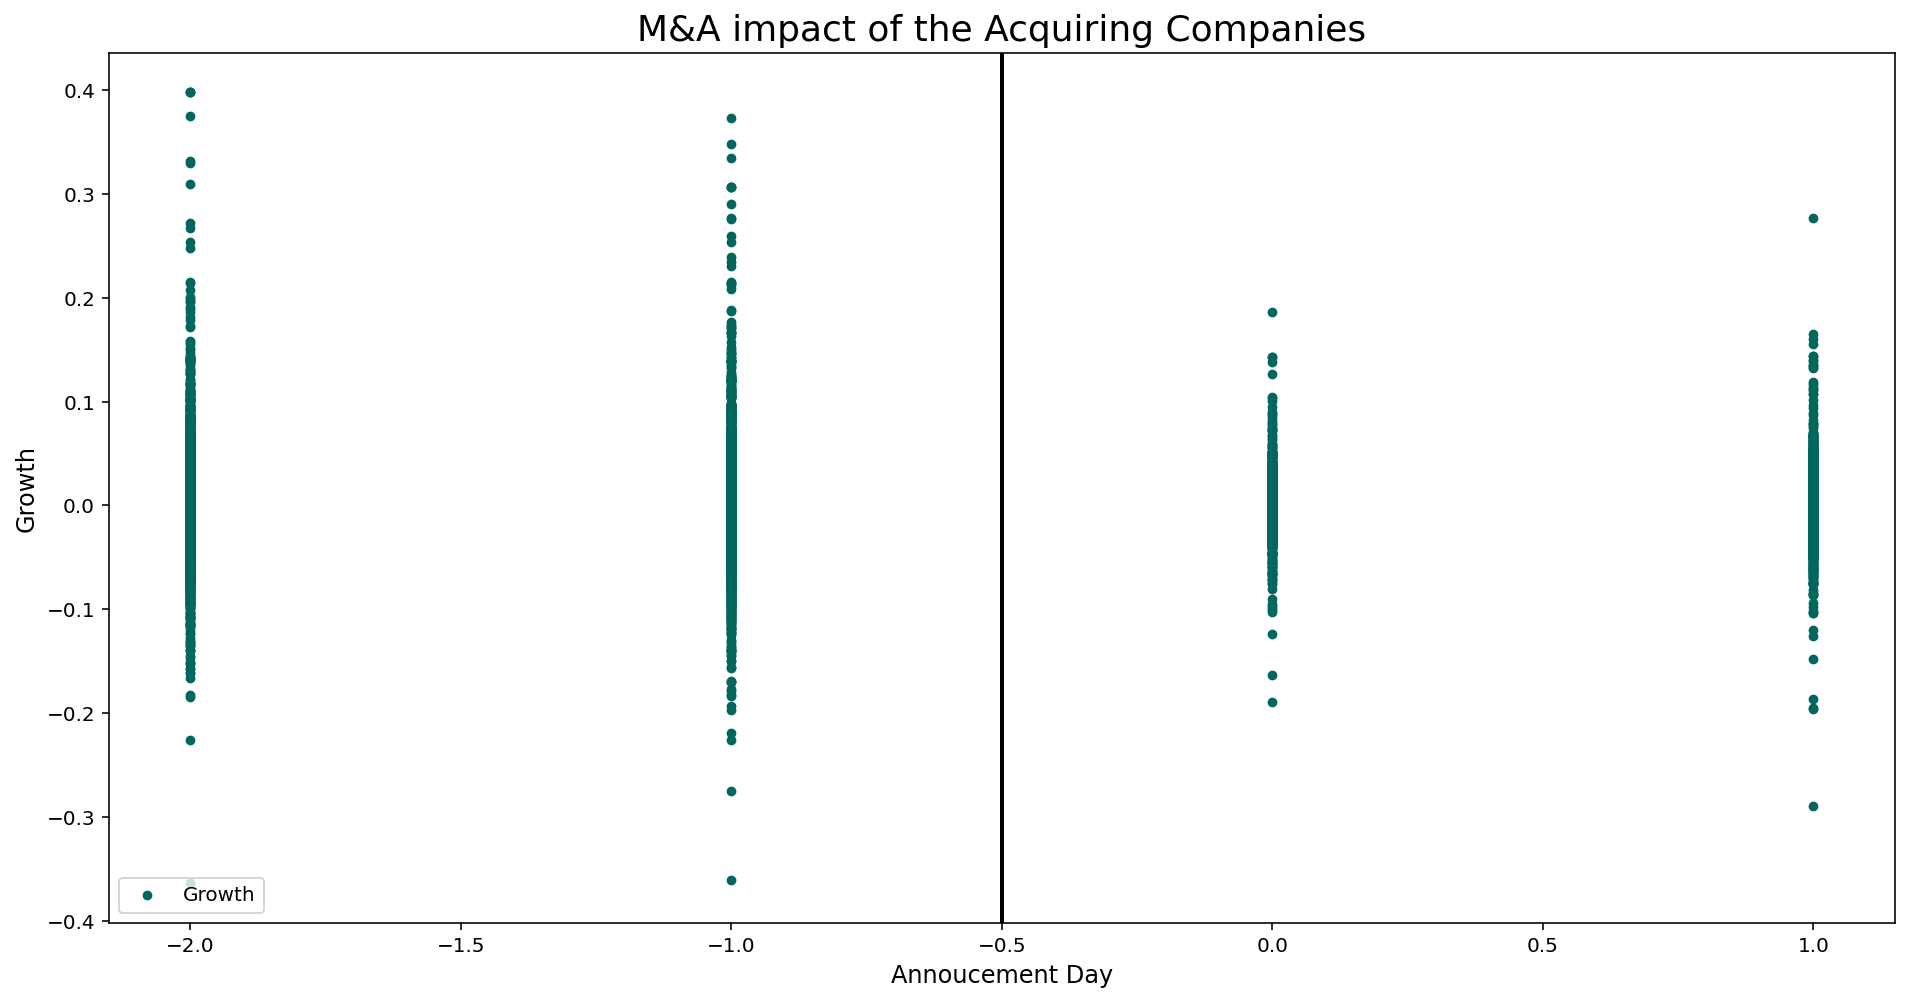

In [24]:
plt.figure(figsize=(16,8))
plt.title('M&A impact of the Acquiring Companies', fontsize=18)
plt.xlabel('Annoucement Day', fontsize=12)
plt.ylabel('Growth', fontsize=12)
plt.scatter(disc01.loc[(disc01['day']>-3), 'day'], 
            disc01.loc[(disc01['day']>-3),'quote'], 
                     color='#01665e', label='Growth', s=15)

plt.axvline(x=-0.5, linewidth=2, color='black')
plt.legend(loc='lower left')
plt.show()


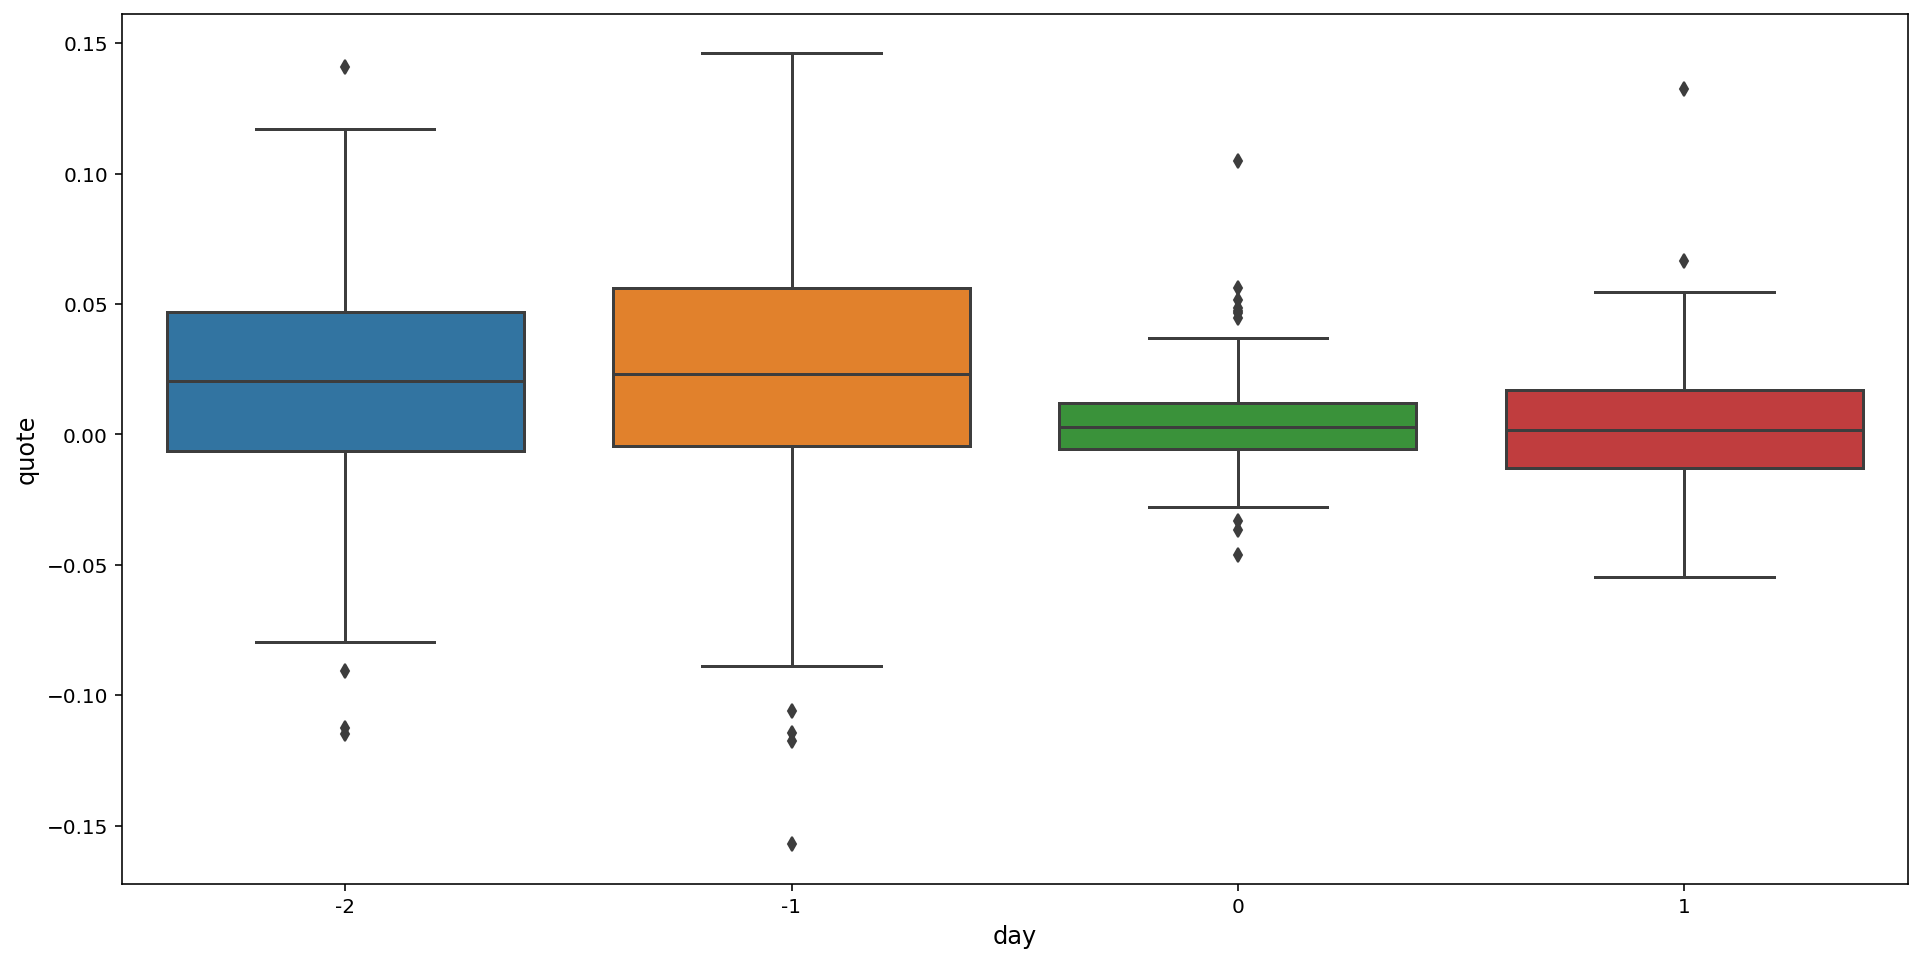

In [6]:
plt.figure(figsize=(16,8))
plt.xlabel('Annoucement Day', fontsize=12)
plt.ylabel('Growth', fontsize=12)
sns.boxplot(x = 'day', y = 'quote', data=disc01.loc[(disc01['day']>-3)&(disc01['Ticker']=='AAPL')])
plt.show()

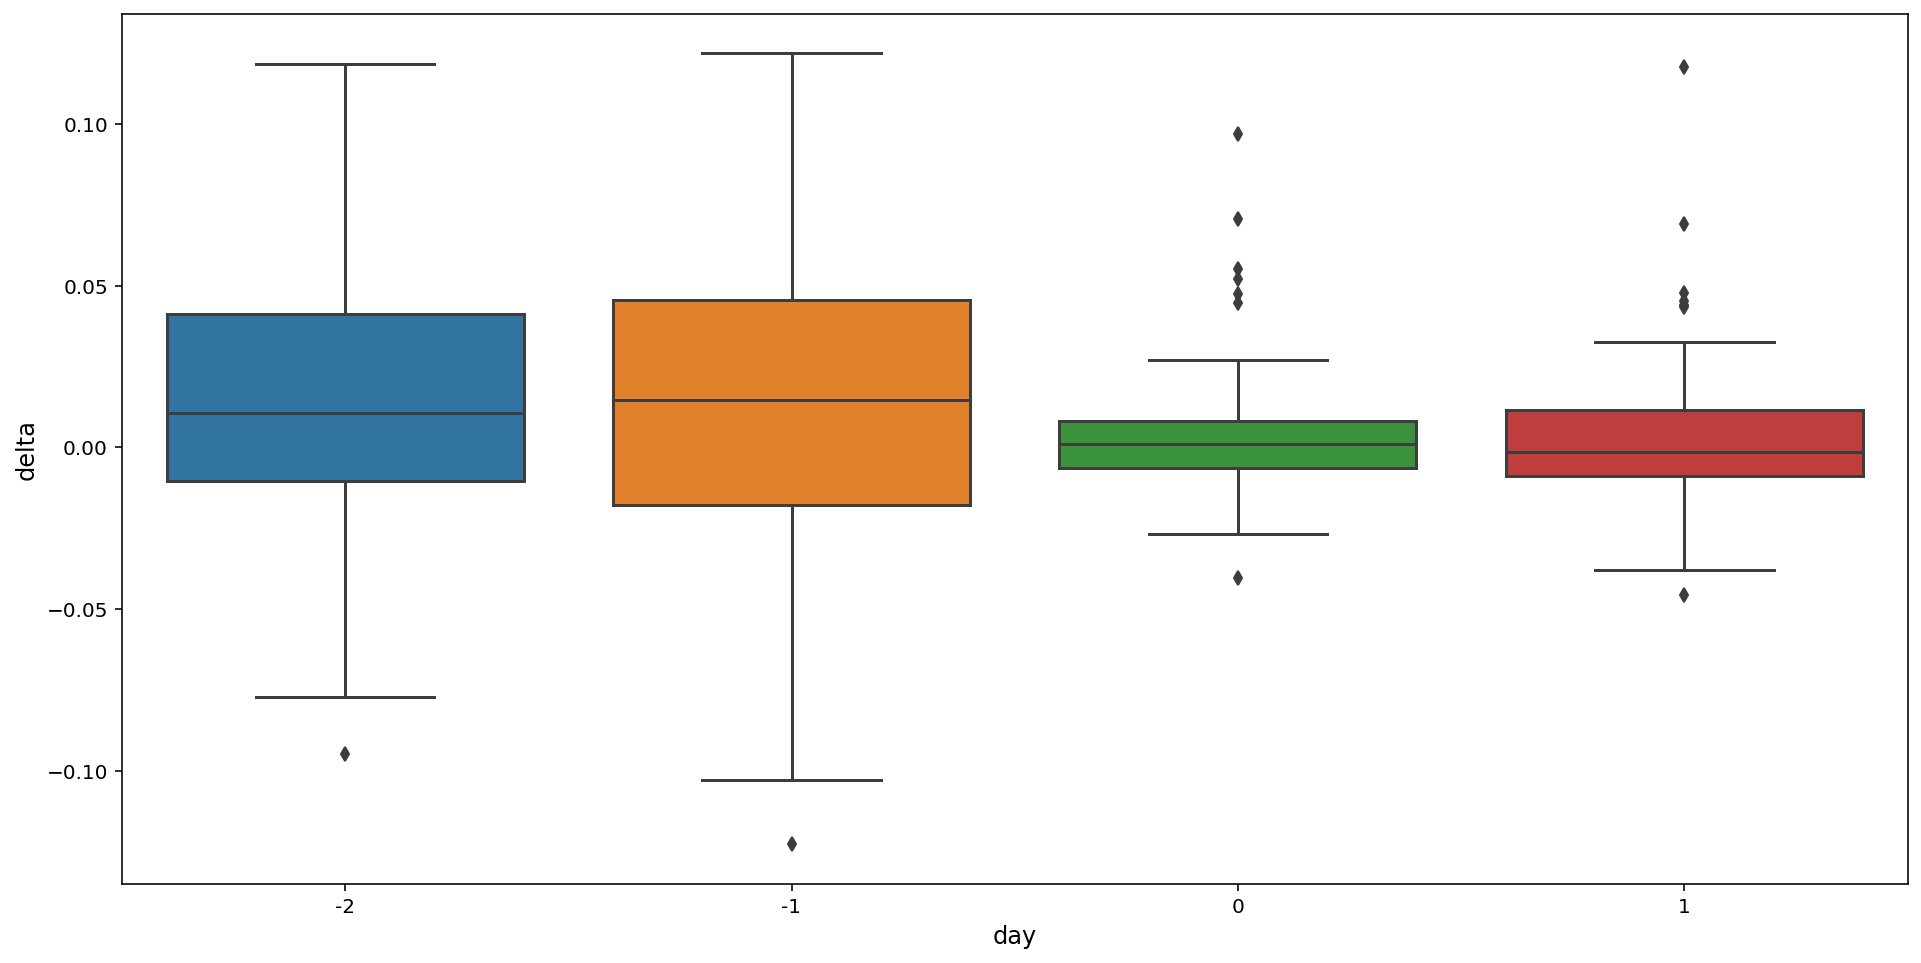

In [7]:
plt.figure(figsize=(16,8))
plt.xlabel('Annoucement Day', fontsize=12)
plt.ylabel('Growth', fontsize=12)
sns.boxplot(x = 'day', y = 'delta', data=disc01.loc[(disc01['day']>-3) &(disc01['Ticker']=='AAPL')])
plt.show()